# 1D noiseless illustrative example


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.problems.multifidelity_functions import Forrester_1b
from mfbml.methods.mf_rbf_kriging import MFRBFKriging
from mfpml.models.co_kriging import CoKriging
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.mf_scale_kriging import ScaledKriging
from mfbml.accuracy_metrics.accuracy_metrics import normalized_mae, normalized_rmse
from mfbml.methods.rbf_regressor import RBFKernelRegression

# import accuracy metrics
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'mfbml.get_methods'

## Get function and design of experiment


In [2]:
# define function
func = Forrester_1b()
# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=1)
sample_x = sampler.get_samples(num_hf_samples=4, num_lf_samples=11)
# update sample_x['hf']
sample_x["hf"] = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
sample_x["lf"] = np.linspace(0, 1, 11, endpoint=True).reshape((-1, 1))

# get response
sample_y = func(sample_x)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

### MF-RBF-Krging


In [3]:
start_time = time.time()
mfrbfkriging_model = MFRBFKriging(
    design_space=func.input_domain, optimizer_restart=20)
mfrbfkriging_model.lf_model = RBFKernelRegression(
    design_space=func.input_domain, params_optimize=False
)
mfrbfkriging_model.train(samples=sample_x, responses=sample_y)
pred_y, pred_std = mfrbfkriging_model.predict(
    x_predict=test_x, return_std=True)

# get prediction of low fidelity
pred_ly = mfrbfkriging_model.predict_lf(test_xl=test_x)
end_time = time.time()
print("time: ", end_time - start_time)

# calculate accuracy metrics
nrmse_mf_rbf_kriging = normalized_rmse(test_hy, pred_y)
nmae_mf_rbf_kriging = normalized_mae(test_hy, pred_y)
r2_mf_rbf_kriging = r2_score(test_hy, pred_y)
cpu_time_mf_rbf_kriging = end_time - start_time
print("nrmse: ", nrmse_mf_rbf_kriging)
print("nmae: ", nmae_mf_rbf_kriging)
print("r2: ", r2_mf_rbf_kriging)
print("cpu_time: ", cpu_time_mf_rbf_kriging)

time:  0.03980517387390137
nrmse:  0.007260479255726432
nmae:  0.017530855041700887
r2:  0.9999822268894117
cpu_time:  0.03980517387390137


## HK method


In [4]:
# train model
start_time = time.time()
hk_model = HierarchicalKriging(
    design_space=func.input_domain, optimizer_restart=20)
hk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
hk_pred_ly = hk_model.predict_lf(test_xl=test_x)
# get prediction of high fidelity
hk_pred_hy, hk_pred_std = hk_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()
# calculate accuracy metrics
nrmse_hk = normalized_rmse(test_hy, hk_pred_hy)
nmae_hk = normalized_mae(test_hy, hk_pred_hy)
r2_hk = r2_score(test_hy, hk_pred_hy)
cpu_time_hk = end_time - start_time

# print accuracy metrics
print("normalized rmse: ", nrmse_hk)
print("normalized mae: ", nmae_hk)
print("r2: ", r2_hk)
print("cpu_time: ", cpu_time_hk)

normalized rmse:  0.022098214384205714
normalized mae:  0.09427769122690363
r2:  0.9998353554989151
cpu_time:  0.4845869541168213


In [5]:
# co-kriging
start_time = time.time()
ck_model = CoKriging(design_space=func.input_domain, optimizer_restart=20)
ck_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
ck_pred_ly = ck_model.predict_lf(x_predict=test_x)
# get prediction of high fidelity
ck_pred_hy, ck_pred_std = ck_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
nrmse = normalized_rmse(test_hy, ck_pred_hy)
nmae = normalized_mae(test_hy, ck_pred_hy)
r2 = r2_score(test_hy, ck_pred_hy)
cpu_time = end_time - start_time

# print accuracy metrics
print("normalized rmse: ", nrmse)
print("normalized mae: ", nmae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

normalized rmse:  0.022147701718384937
normalized mae:  0.09430552221673145
r2:  0.9998346172545914
cpu_time:  0.5257365703582764


In [6]:
# scaled kriging
start_time = time.time()
sk_model = ScaledKriging(design_space=func.input_domain, optimizer_restart=20)
sk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
sk_pred_ly = sk_model.predict_lf(test_xl=test_x)
# get prediction of high fidelity
sk_pred_hy, sk_pred_std = sk_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
nrmse_sk = normalized_rmse(test_hy, sk_pred_hy)
nmae_sk = normalized_mae(test_hy, sk_pred_hy)
r2_sk = r2_score(test_hy, sk_pred_hy)
cpu_time_sk = end_time - start_time

# print accuracy metrics
print("normalized mse: ", nrmse_sk)
print("normalized mae: ", nmae_sk)
print("r2: ", r2_sk)
print("cpu_time: ", cpu_time_sk)

normalized mse:  0.972347293816678
normalized mae:  2.2144341560251832
r2:  0.6812312899418581
cpu_time:  0.20921087265014648


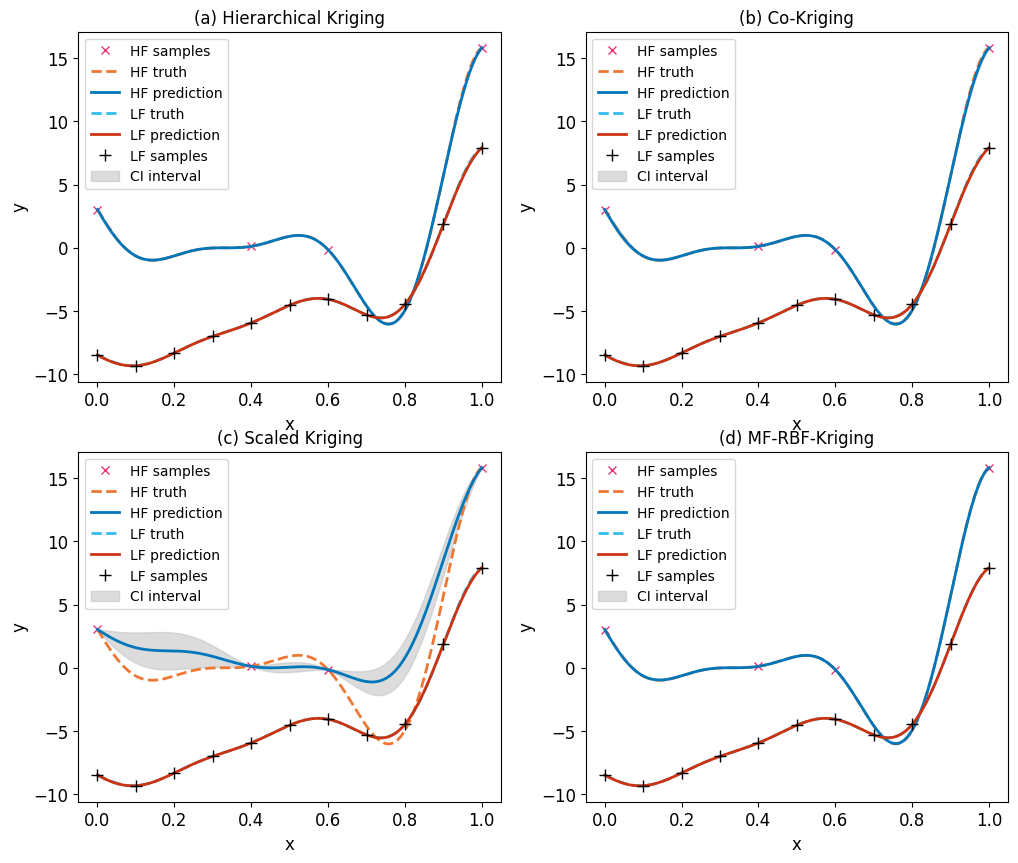

In [7]:
# plot results in 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[1, 1].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[1, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[1, 1].plot(test_x, pred_y, "-", color="#0077BB",
              linewidth=2, label="HF prediction")
ax[1, 1].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[1, 1].plot(test_x, pred_ly, "-", color="#CC3311",
              linewidth=2, label="LF prediction")
ax[1, 1].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[1, 1].fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1, 1].set_title("(d) MF-RBF-Kriging")
ax[1, 1].set_ylabel("y", fontsize=12)
ax[1, 1].set_xlabel("x", fontsize=12)
ax[1, 1].legend()
# for hierarchical kriging
ax[0, 0].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[0, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[0, 0].plot(
    test_x, hk_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[0, 0].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[0, 0].plot(
    test_x, hk_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[0, 0].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[0, 0].fill_between(
    test_x.flatten(),
    (hk_pred_hy - 2 * hk_pred_std).flatten(),
    (hk_pred_hy + 2 * hk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0, 0].set_title("(a) Hierarchical Kriging")
ax[0, 0].set_ylabel("y", fontsize=12)
ax[0, 0].set_xlabel("x", fontsize=12)
ax[0, 0].legend()
# for co-kriging
ax[0, 1].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[0, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[0, 1].plot(
    test_x, ck_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[0, 1].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[0, 1].plot(
    test_x, ck_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[0, 1].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[0, 1].fill_between(
    test_x.flatten(),
    (ck_pred_hy - 2 * ck_pred_std).flatten(),
    (ck_pred_hy + 2 * ck_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0, 1].set_title("(b) Co-Kriging")
ax[0, 1].set_ylabel("y", fontsize=12)
ax[0, 1].set_xlabel("x", fontsize=12)
ax[0, 1].legend()
# for scaled kriging
ax[1, 0].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[1, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[1, 0].plot(
    test_x, sk_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[1, 0].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[1, 0].plot(
    test_x, sk_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[1, 0].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[1, 0].fill_between(
    test_x.flatten(),
    (sk_pred_hy - 2 * sk_pred_std).flatten(),
    (sk_pred_hy + 2 * sk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1, 0].set_title("(c) Scaled Kriging")
ax[1, 0].set_ylabel("y", fontsize=12)
ax[1, 0].set_xlabel("x", fontsize=12)
ax[1, 0].legend()
# set the font size of axis
for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis="both", which="major", labelsize=12)
        ax[i, j].tick_params(axis="both", which="minor", labelsize=12)
plt.savefig("mf_rbf_gpr_noiseless_1d.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noiseless_1d.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noiseless_1d.svg", bbox_inches="tight", dpi=300)
plt.show()
# plt.savefig("test_idea.png")

In [8]:
# save the results into a pandas dataframe

df = pd.DataFrame(columns=["nrmse", "nmae", "r2", "cpu_time"])
df.loc["hierarchical_kriging"] = [nrmse_hk, nmae_hk, r2_hk, cpu_time_hk]
df.loc["co_kriging"] = [nrmse, nmae, r2, cpu_time]
df.loc["scaled_kriging"] = [nrmse_sk, nmae_sk, r2_sk, cpu_time_sk]
df.loc["mf_rbf_kriging"] = [
    nrmse_mf_rbf_kriging,
    nmae_mf_rbf_kriging,
    r2_mf_rbf_kriging,
    cpu_time_mf_rbf_kriging,
]
# save the results into a csv file
df.to_csv("result_of_illustrative_example.csv")

# print the results
print(df)

                         nrmse      nmae        r2  cpu_time
hierarchical_kriging  0.022098  0.094278  0.999835  0.484587
co_kriging            0.022148  0.094306  0.999835  0.525737
scaled_kriging        0.972347  2.214434  0.681231  0.209211
mf_rbf_kriging        0.007260  0.017531  0.999982  0.039805
